<a href="https://colab.research.google.com/github/LeoPedroza98/RedeNeuralConvolucional/blob/main/RedeNeuralConvolucional_AT4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F

torch.cuda.is_available()

True

In [ ]:
num_workers = 0

batch_size = 200

validation_size = 0.3

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
testdata = datasets.CIFAR10('data', train=False, download=True, transform=transform)

num_total_train = len(trainset)
idx_total = list(range(num_total_train))
np.random.shuffle(idx_total)
split = int(np.floor(validation_size * num_total_train))

train_idx, valid_idx = idx_total[split:], idx_total[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(trainset, batch_size=batch_size,
                          sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(trainset, batch_size=batch_size,
                          sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(testdata, batch_size=batch_size,
                         num_workers=num_workers)

classes = ['aviao', 'automovel', 'passaro', 'gato', 'veado',
           'cachorro', 'sapo', 'cavalo', 'navio', 'caminhao']

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))

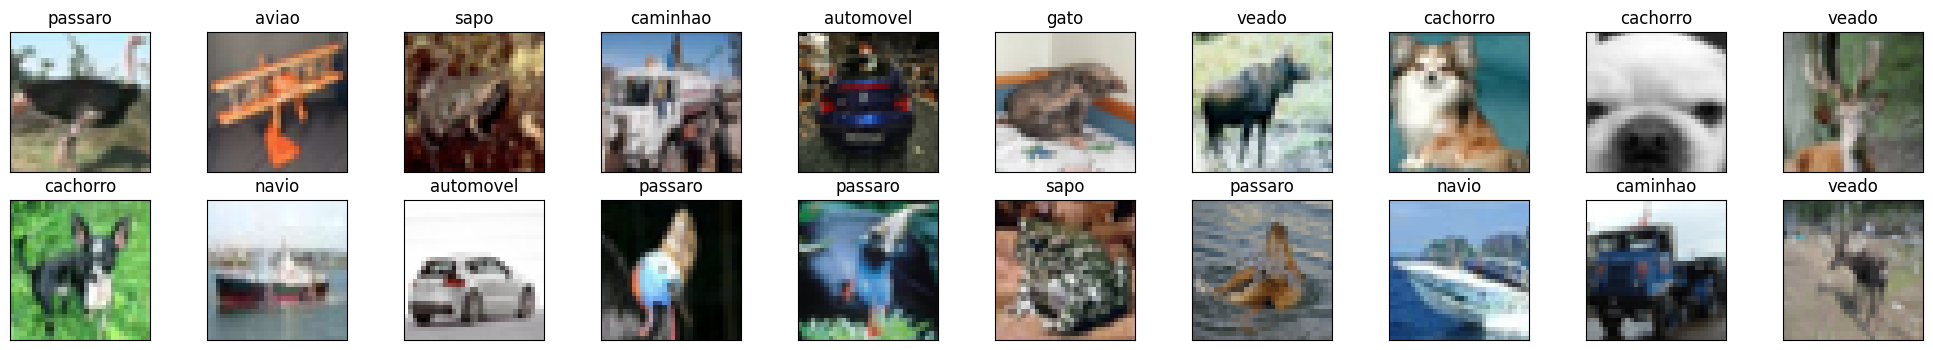

In [ ]:
  images, labels = next(iter(train_loader))
  images = images.numpy()

  fig = plt.figure(figsize=(25, 4))

  for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

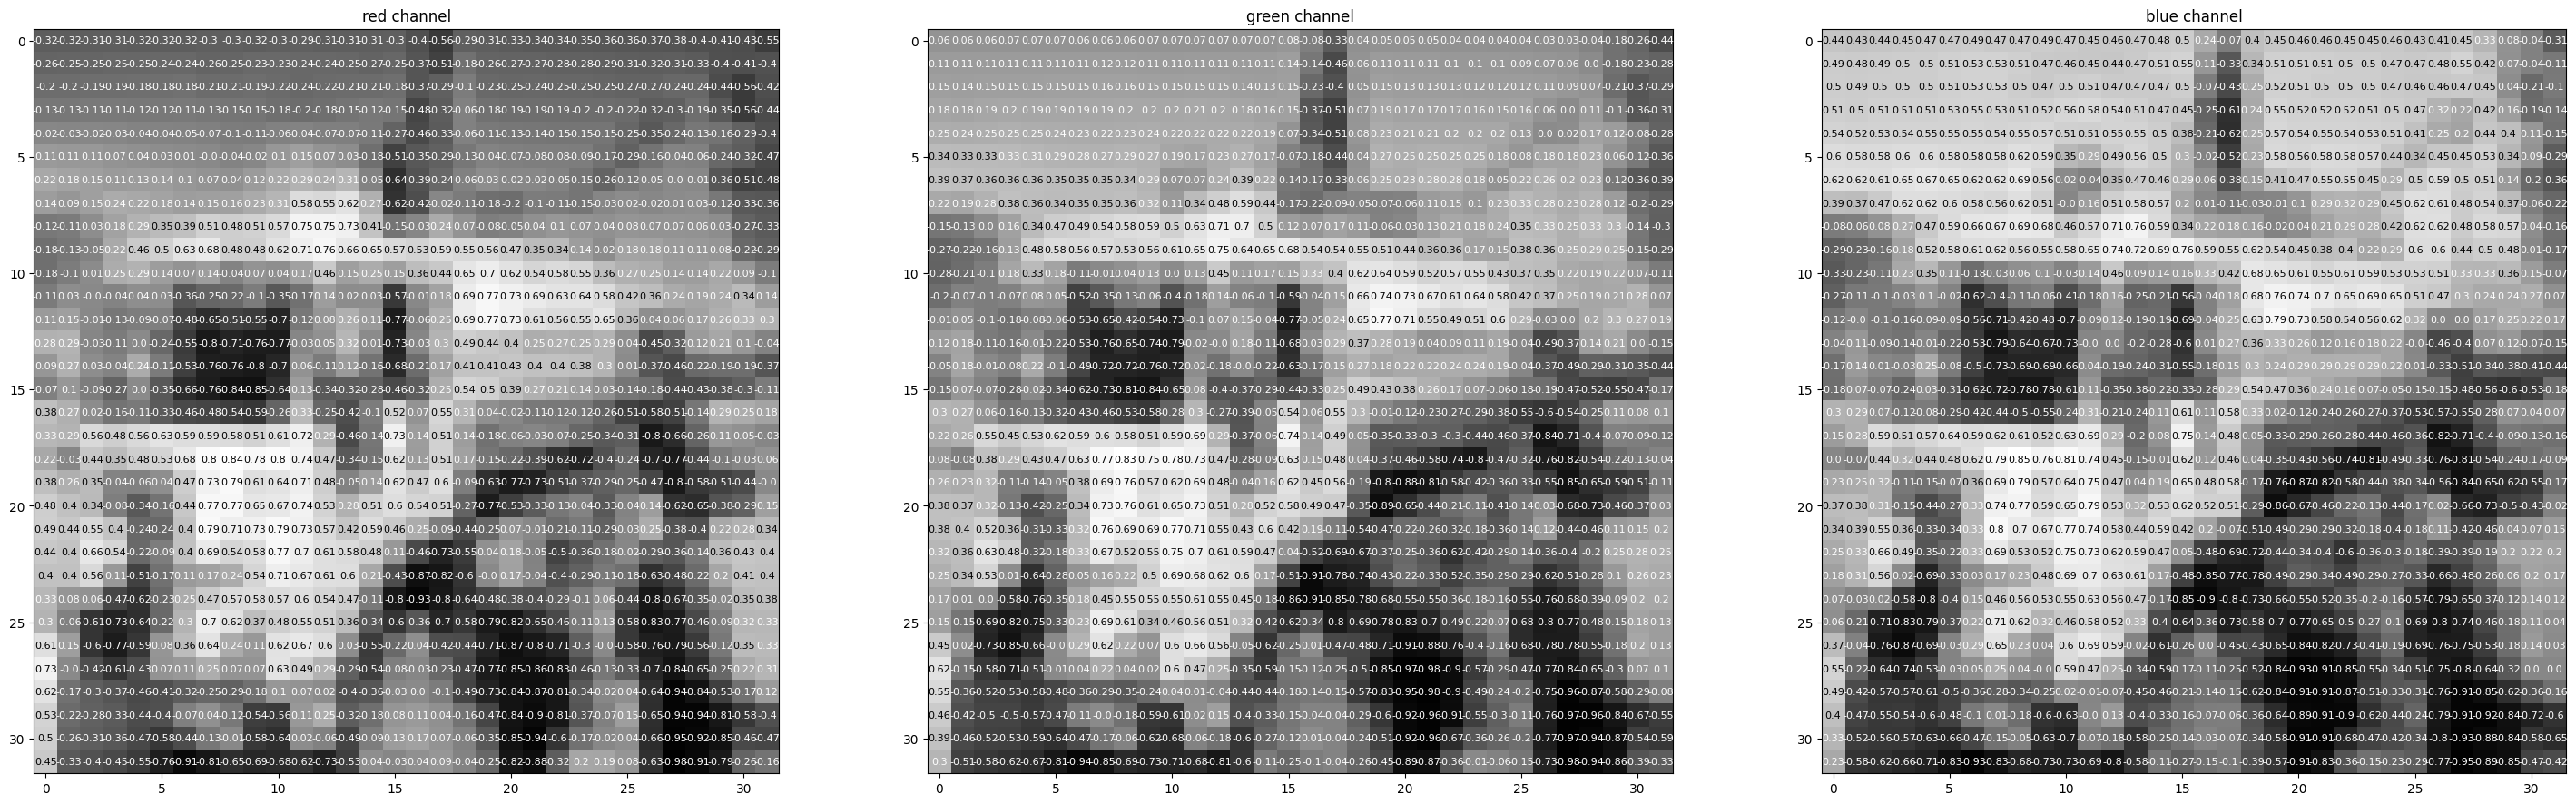

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
from torch import nn
import torch.nn.functional as F

class CustomNet(nn.Module):
  def __init__(self):
    super().__init__()
    # Camada convolucional com 16 filtros de 3x3, padding de 1 e stride de 1
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    # Camada convolucional com 32 filtros de 3x3, padding de 1 e stride de 1
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    # Camada convolucional com 64 filtros de 3x3, padding de 1 e stride de 1
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    # Camada convolucional com 128 filtros de 3x3, padding de 1 e stride de 1
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    # Camada convolucional com 256 filtros de 3x3, sem padding e stride de 1
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3)

    # Camada totalmente conectada com 128 neurônios
    self.fc1 = nn.Linear(256*6*6, 128)
    # Camada de saída com 10 neurônios (o número de classes)
    self.output = nn.Linear(128, 10)
    # Camada de pooling máximo com janela de 2x2 e stride de 2
    self.pool = nn.MaxPool2d(2, 2)
    # Camada de dropout com probabilidade de desativar um neurônio de 0.2
    self.dropout = nn.Dropout(p=.2)
    # Camada de normalização em lote para as camadas convolucionais
    self.bn_conv = nn.BatchNorm2d(256)
    # Camada de normalização em lote para a camada totalmente conectada
    self.bn_fc = nn.BatchNorm1d(128)

  def forward(self, x):
    # Aplica a primeira camada convolucional e a função ReLU
    x = F.relu(self.conv1(x))
    # Aplica a segunda camada convolucional e a função ReLU
    x = F.relu(self.conv2(x))
    # Aplica a camada de pooling máximo
    x = self.pool(x)
    # Aplica a terceira camada convolucional e a função ReLU
    x = F.relu(self.conv3(x))
    # Aplica a camada de pooling máximo
    x = self.pool(x)
    # Aplica a quarta camada convolucional e a função ReLU
    x = F.relu(self.conv4(x))
    # Aplica a quinta camada convolucional e a função ReLU
    x = F.relu(self.conv5(x))
    # Aplica a camada de normalização em lote para as camadas convolucionais
    x = self.bn_conv(x)

    # Redimensiona o tensor para um vetor unidimensional
    x = x.view(x.size(0), -1)

     # Aplica a camada totalmente conectada e a função ReLU
    x = F.relu(self.fc1(x))
    # Aplica a camada de dropout
    x = self.dropout(x)
    # Aplica a camada de normalização em lote para a camada totalmente conectada
    x = self.bn_fc(x)
    # Aplica a camada de saída e a função softmax para obter as probabilidades das classes
    x = F.log_softmax(self.output(x), dim=1)

    return x


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomNet()
model.to(device)

min_valid_loss = np.Inf

criterion = nn.NLLLoss()

lr = .001

optimizer = optim.Adam(model.parameters(), lr=lr)

n_epochs = 15

for epoch in range(1, n_epochs + 1):
  train_loss = 0.
  valid_loss = 0.

  model.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(images)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()

    model.eval()
  with torch.no_grad():
    for images_val, label_val in valid_loader:
      images_val, label_val = images_val.to(device), label_val.to(device)
      output = model(images_val)

      loss = criterion(output, label_val)
      valid_loss += loss.item()

  train_loss = train_loss/len(train_loader)
  valid_loss = valid_loss/len(valid_loader)

  print(f'Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}')

  if valid_loss < min_valid_loss:
    print(f'Validation loss has decreased ({min_valid_loss} --> {valid_loss}). Saving the model...')
    torch.save(model.state_dict(), 'lenet_cifar10.pt')
    min_valid_loss = valid_loss

Epoch: 1 	Training Loss: 1.7112584025519235 	Validation Loss: 1.4359207725524903
Validation loss has decreased (inf --> 1.4359207725524903). Saving the model...
Epoch: 2 	Training Loss: 1.3349694115774973 	Validation Loss: 1.2312793827056885
Validation loss has decreased (1.4359207725524903 --> 1.2312793827056885). Saving the model...
Epoch: 3 	Training Loss: 1.1247674598012651 	Validation Loss: 1.1029469736417135
Validation loss has decreased (1.2312793827056885 --> 1.1029469736417135). Saving the model...
Epoch: 4 	Training Loss: 0.9695561872209821 	Validation Loss: 0.9631151350339254
Validation loss has decreased (1.1029469736417135 --> 0.9631151350339254). Saving the model...
Epoch: 5 	Training Loss: 0.856437839439937 	Validation Loss: 0.8683562771479288
Validation loss has decreased (0.9631151350339254 --> 0.8683562771479288). Saving the model...
Epoch: 6 	Training Loss: 0.7480210532460894 	Validation Loss: 0.8111203193664551
Validation loss has decreased (0.8683562771479288 --> 0